# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [1]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import gc
import pickle as pkl

# Data manipulation
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import erf, erfinv
from scipy.integrate import quad
from scipy.signal import savgol_filter, correlate, fftconvolve
from scipy.sparse import csr_matrix, dia_matrix, csc_matrix, coo_matrix
from scipy import fftpack
import torch
from functools import reduce
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'torch device: {device}')

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
import matplotlib.pylab as plb

# From alens_analysis.py
import alens_analysis as aa
from alens_analysis.colormaps import register_cmaps
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
import alens_analysis.chromatin.chrom_poly_stats as cps
import alens_analysis.helpers as ahlp
import alens_analysis.read_func as arf
from alens_analysis import cluster_analysis as cla

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'
cond_path = Path.home() / 'ceph/DATA/Chromatin/CondCharPaper'

torch device: cuda


In [2]:
torch.__version__

import warnings

warnings.filterwarnings('ignore')

'1.13.0'

### Style settings

In [3]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

register_cmaps()
plt.rcParams['image.cmap'] = 'YlOrRd'
#plt.rcParams['image.cmap'] = 'emct8'
#plt.rcParams['image.cmap'] = 'warm'
#plt.rcParams['image.cmap'] = 'twilight'
#plt.rcParams['image.cmap'] = 'coolwarm'
#plt.rcParams['image.cmap'] = 'RdYlBu_r'
        

# Functions

# Data generation

## Connection matrix

In [4]:
def get_param_stats(h5_path, param_ind=0):
    with h5py.File(h5_path, 'r') as h5d:
        param = h5d.attrs['param']

        # Store parameter values and associated graphing colors
        param_val = sorted(list(h5d.keys()), key=lambda x: float(x))[1]
         
        h5_data = h5d[param_val]
        avg_clps_time = np.mean(h5_data.attrs['collapse_times'])
        std_clps_time = np.std(h5_data.attrs['collapse_times'])
        rog_avg = np.mean(h5_data.attrs['avg_collapse_rog'])
        rog_std = np.std(h5_data.attrs['avg_collapse_rog'])
        return avg_clps_time , std_clps_time, rog_avg, rog_std 


In [5]:
def save_msd_run_data(run_path, param_str, 
                    ss_ind = 1, end_ind = -1,
                    start_bead = 0, end_bead = None,
                  ):
    # Make analysis directory if it doesn't exist
    anal_path = (run_path / 'analysis')
    anal_path.mkdir(exist_ok=True)


    # Create an hdf5 file
    h5_path = anal_path / 'msd_run_data.h5'
    if h5_path.exists():
        h5_path.unlink()
    h5_file = h5py.File(h5_path, 'w')

    # Add label string as attribute
    h5_file.attrs['param'] = param_str

    sim_path = run_path / 'simulations'
    try:
        mp = re.compile(f'{param_str}(\d*\.?\d+)')
        param_dirs = sorted(
            [pd for pd in sim_path.glob('*/')],
            key=lambda x: float(mp.match(str(x.name))[1]))

    
        for i, pd in tqdm(enumerate(param_dirs)):
            msd_list = []
            sd_h5_data_lst = []
            for h5p in pd.glob('s*/analysis/raw*.h5'):
                try:
                    sd_h5_data_lst += [h5py.File(h5p, 'r')]
                except:
                    print(f'Could not open {h5p}.')
            if len(sd_h5_data_lst) == 0:
                print(f'No data files found for parameter directory {pd}')
                continue

            for h5_data in sd_h5_data_lst:
                # Get data from seed h5 file
                time_arr = h5_data['time'][ss_ind:end_ind]
                sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                          :, ss_ind:end_ind]
                com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

                msd  = cps.poly_bead_msd(com_arr, device=device)
                msd_list += [msd.tolist()]

            for h5d in sd_h5_data_lst:
                h5d.close()

            # Make sure the runs are all the same length
            min_length = min([len(_) for _ in msd_list])
            msd_arrs = np.array([_[:min_length] for _ in msd_list])

            # Create dataset
            label = re.split(r'(^[^\d]+)', str(pd.name))[1:][1]
            data_arr = np.hstack((time_arr[:min_length][:,np.newaxis],
                                  msd_arrs.mean(axis=0)[:, np.newaxis],
                                  msd_arrs.std(axis=0)[:, np.newaxis]))
            print(data_arr.shape)
            d_set = h5_file.create_dataset(label, data=data_arr)
            d_set.attrs['seeds'] = msd_arrs.shape[0]

    except:
        raise
    finally:
        for h5d in sd_h5_data_lst:
            h5d.close()


In [6]:
def graph_msd_ax(fig, ax, h5_path, 
                ci_bound = .95,
                label_str= '{}',
                show_legend=False,
                send_cut_ind = 2,
                fend_cut_ind = -1,
                          ):
    with h5py.File(h5_path, 'r') as h5d:
        param = h5d.attrs['param']

        # Store parameter values and associated graphing colors
        param_vals = sorted(list(h5d.keys()), key=lambda x: float(x))
        log_pvs = np.log10([float(p)+.000001 for p in param_vals]) 
        log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
        colors = plb.cm.plasma_r(log_pvs)

        for i, pv in enumerate(reversed(param_vals)):
            h5_data = h5d[pv]
            time_arr = h5_data[send_cut_ind:fend_cut_ind,0]
            mean_msd_arr = h5_data[send_cut_ind:fend_cut_ind,1]
            std_msd_arr = h5_data[send_cut_ind:fend_cut_ind,2]

            _ = ax.plot(time_arr, mean_msd_arr,
                        color=colors[i], label=label_str.format(pv))
            ci = ((std_msd_arr/np.sqrt(h5_data.attrs['seeds'])) *
                  (np.sqrt(2)*erfinv(ci_bound)))
            _ = ax.fill_between(time_arr, 
                                mean_msd_arr - ci, mean_msd_arr + ci, 
                                color=colors[i], alpha=.25)

        # _ = ax.axhline(0.486918, c='k', linestyle=':', linewidth=4, label='SAW $R_g$')
        
        # _ = ax.set_ylabel('Mean Squared Displacement\n' + r'$MSD$ ($\mu$m$^2$)')
        # _ = ax.set_xlabel(r'Lag time $\tau$ (sec)')
        _ = ax.set_ylabel(r'$MSD$ [$\mu$m$^2$]')
        _ = ax.set_xlabel(r'$\tau$ [sec]')
        _ = ax.set_yscale('log')
        _ = ax.set_xscale('log')
        if show_legend:
            _ = ax.legend(loc='center left', bbox_to_anchor=(1.0, .5))

In [7]:
def make_single_graph_msd(fig, ax, h5_path, key, color='k', 
                          ci_bound = .95, label_str= '{}',
                            send_cut_ind = 2,
                            fend_cut_ind = -1,
                            show_legend = False
                          ):
    with h5py.File(h5_path, 'r') as h5d:
          h5_data = h5d[key]
          time_arr = h5_data[send_cut_ind:fend_cut_ind,0]
          mean_msd_arr = h5_data[send_cut_ind:fend_cut_ind,1]
          std_msd_arr = h5_data[send_cut_ind:fend_cut_ind,2]

          _ = ax.plot(time_arr, mean_msd_arr,
                      color=color, label=label_str.format(key))
          ci = ((std_msd_arr/np.sqrt(h5_data.attrs['seeds'])) *
                (np.sqrt(2)*erfinv(ci_bound)))
          _ = ax.fill_between(time_arr, 
                              mean_msd_arr - ci, mean_msd_arr + ci, 
                              color=color, alpha=.25)

        # _ = ax.axhline(0.486918, c='k', linestyle=':', linewidth=4, label='SAW $R_g$')
        
#     _ = ax.set_ylabel('Mean Squared Displacement\n' + r'$MSD$ ($\mu$m$^2$)')
    _ = ax.set_ylabel( r'$MSD$ [$\mu$m$^2$]')
    _ = ax.set_xlabel(r'$\tau$ [sec]')
    _ = ax.set_yscale('log')
    _ = ax.set_xscale('log')
    if show_legend:
        _ = ax.legend(loc='center left', bbox_to_anchor=(1.0, .5))

In [8]:
def get_connect_smat(prot_arr):
    nlinks = prot_arr.shape[0]
    xlinks = (prot_arr[:,-1] >= 0)
    xlink_coords = prot_arr[xlinks][:,-2:].astype(int)
    data = np.ones((xlink_coords.shape[0]))
    return csr_matrix((data,(xlink_coords[:,0],xlink_coords[:,1])),shape=[nlinks,nlinks])

In [9]:
def get_connect_torch_smat(prot_arr):
    nlinks = prot_arr.shape[0]
    xlinks = (prot_arr[:,-1] >= 0)
    xlink_coords = prot_arr[xlinks][:,-2:].astype(int)
    data = np.ones((xlink_coords.shape[0]))
    tmp = coo_matrix((data,(xlink_coords[:,0],xlink_coords[:,1])),shape=[nlinks,nlinks])
    tmp = torch.from_numpy(tmp.toarray()).to(device=device)
    return tmp.to_sparse_csr()

In [10]:
def connect_autocorr(connect_mat_list):
    n = len(connect_mat_list)
    autocorr_arr = np.zeros(n)
    for i in tqdm(range(n)):
        for j in range(n-i):
            autocorr_arr[i] += connect_mat_list[j].multiply(connect_mat_list[j+i]).sum()
        autocorr_arr[i] /= float(n-i)
    return autocorr_arr

In [11]:
def save_connect_data(run_path, param_str):
    anal_path = run_path / 'analysis'
    anal_path.mkdir(exist_ok=True)

    # Create an hdf5 file
    h5_path = anal_path / 'connect_run_data.h5'
    if h5_path.exists():
        h5_path.unlink()
    h5_file = h5py.File(h5_path, 'w')

    # Add label string as attribute
    h5_file.attrs['param'] = param_str

    sim_path = run_path / 'simulations'
    try:
        mp = re.compile(f'{param_str}(\d*\.?\d+)')
        param_dirs = sorted(
            [pd for pd in sim_path.glob('*/')],
            key=lambda x: float(mp.match(str(x.name))[1]))

        for i, pd in tqdm(enumerate(param_dirs)):
            ac_arrs = []
            sd_h5_data_lst = []
            for h5p in pd.glob('s*/analysis/connect_analysis.h5'):
                try:
                    sd_h5_data_lst += [h5py.File(h5p, 'r')]
                except:
                    print(f'Could not open {h5p}.')
                if len(sd_h5_data_lst) == 0:
                    print(f'No data files found for parameter directory {pd}')
                    continue
            for h5_data in sd_h5_data_lst:
                time_arr = h5_data['time'][...]
                ac_arrs += [h5_data['autocorr'][...]]

            for h5_data in sd_h5_data_lst:
                h5_data.close()

            min_length = min([_.size for _ in ac_arrs])
            ac_arrs = np.array([_[:min_length] for _ in ac_arrs])

            label = re.split(r'(^[^\d]+)', str(pd.name))[1:][1]
            data_arr = np.hstack((time_arr[:min_length][:,np.newaxis],
                                  ac_arrs.mean(axis=0)[:, np.newaxis],
                                  ac_arrs.std(axis=0)[:, np.newaxis]))
            d_set = h5_file.create_dataset(label, data=data_arr)
            d_set.attrs['seeds'] = ac_arrs.shape[0]

    except:
        raise
    finally:
        for h5d in sd_h5_data_lst:
            h5d.close()


In [12]:
def graph_connect_ac_ax(fig, ax, h5_path, 
                        colorbar_label='', 
                        ci_bound = .95,
                        label_str= '{}',
                        show_legend=True,
                        send_cut_ind = 2,
                        fend_cut_ind = -1,
                        add_exp_fit=False,
                        ):
    with h5py.File(h5_path, 'r') as h5d:
        param = h5d.attrs['param']

        # Store parameter values and associated graphing colors
        param_vals = sorted(list(h5d.keys()), key=lambda x: float(x))
        log_pvs = np.log10([float(p) for p in param_vals])
        log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
        colors = plb.cm.plasma(log_pvs)

        for i, pv in enumerate(param_vals):
            h5_data = h5d[pv]
            time_arr = h5_data[send_cut_ind:fend_cut_ind,0]
            mean_ac_arr = h5_data[send_cut_ind:fend_cut_ind,1]
            std_ac_arr = h5_data[send_cut_ind:fend_cut_ind,2]

            _ = ax.plot(time_arr, mean_ac_arr,
                        color=colors[i], label=label_str.format(pv))

            ci = ((std_ac_arr/np.sqrt(h5_data.attrs['seeds'])) *
                  (np.sqrt(2)*erfinv(ci_bound)))
            _ = ax.fill_between(time_arr, 
                                mean_ac_arr - ci, mean_ac_arr + ci, 
                                color=colors[i], alpha=.25)

            if add_exp_fit:
                full_time_arr = np.logspace(-4, 3, 1000)
                _ = ax.plot(full_time_arr, mean_ac_arr[0]*np.exp(-float(pv)*full_time_arr),
                            color=colors[i], linestyle='--')

        # _ = ax.axhline(0.486918, c='k', linestyle=':', linewidth=4, label='SAW $R_g$')
        _ = ax.set_ylabel(r'$C_c$')
        # _ = ax.set_ylabel('Connection autocorrelation\n' + r'$C_c$')
        _ = ax.set_xlabel(r'$\tau$ [sec]')
        # _ = ax.set_xlabel(r'Lag time $\tau$ [sec]')
        _ = ax.set_xscale('log')
        _ = ax.set_yscale('log')
        # _ = ax.set_ylim(.09, 1)
        if show_legend:
            _ = ax.legend(loc='center left', bbox_to_anchor=(1.0, .5))

In [13]:
def elastica_rotation_msd(t, **kwargs):
    visc = kwargs["viscosity"]
    kappa = kwargs["kappa"]
    beta = kwargs["beta"]
    diam = kwargs["diam"]
    rog = kwargs["rog"]
    drag_bead = 3. * np.pi * visc * diam
    drag_rot = 8. * np.pi * visc * (rog)**3
    tau_bead = drag_bead / kappa
    tau_rot = drag_rot * beta *.5 *(np.sqrt(800)) 
    print("Tau bead = ", tau_bead)
    print("Tau rot = ", tau_rot)
    return (6./(beta*kappa) * (1.-np.exp(-t/tau_bead)) + (2.*(rog**2)*(1-np.exp(-t/tau_rot))))
    
    

In [14]:
def elastica_2species_rotation_msd(t, **kwargs):
    visc = kwargs["viscosity"]
    kappa1 = kwargs["kappa1"]
    kappa2 = kwargs["kappa2"]
    beta = kwargs["beta"]
    diam = kwargs["diam"]
    rog = kwargs["rog"]
    drag_bead = 3. * np.pi * visc * diam
    drag_rot = 8. * np.pi * visc * (rog)**3
    tau_bead1 = drag_bead / kappa1
    tau_bead2 = drag_bead / kappa2
    tau_rot = drag_rot * beta *.5 *(np.sqrt(800)) 
    print("Tau bead1 = ", tau_bead1)
    print("Tau bead2 = ", tau_bead1)
    print("Tau rot = ", tau_rot)
    return (6./(beta*kappa1) * (1.-np.exp(-t/tau_bead1)) 
            +(6./(beta*kappa2) * (1.-np.exp(-t/tau_bead2)) 
              + (2.*(rog**2)*(1-np.exp(-t/tau_rot)))))
    
    

Avg RoG = 0.12199690192937851
Tau bead =  0.003769911184307752
Tau rot =  146.33987313678915


Text(0.5, 0, '')

(0.1, 1000)

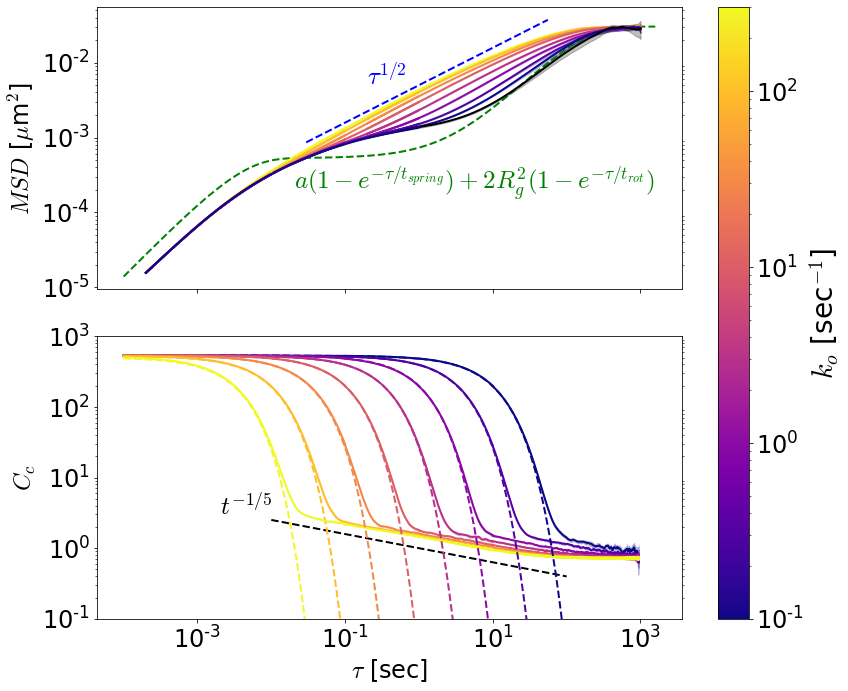

In [77]:
fig, axarr = plt.subplots(2,1, figsize=(12, 10), sharex=True)

# MSD graph
time_arr = np.logspace(-4, 3.2, 100)
_, _, avg_rog, _ = get_param_stats(cond_path/"22-10-16_aLc1_line800_sticky55nm_kod.1-300/analysis/rog_run_data.h5")
print("Avg RoG = {avg_rog}".format(avg_rog=avg_rog))
pdict = {"viscosity": 1, 
         "kappa": 50, 
         "beta": 1./.00441, 
         "diam": .02, 
         "rog": avg_rog}
_ = axarr[0].plot(time_arr, elastica_rotation_msd(time_arr, **pdict),
                                               c='g', linestyle='--', label= r"$a(1-\exp[t/\tau_{{spring}}])+2R_g^2(1-\exp[t/\tau_{{rot}}])$")
_ = axarr[0].plot(time_arr[34:80], .005*np.sqrt(time_arr[34:80]), c='b', linestyle='--', label= "$\propto t^{1/2}$")
_ = axarr[0].text(0.2, 0.005, r"$\tau^{1/2}$", c='b', fontsize=25)
_ = axarr[0].text(0.02, 0.0002, r"$a(1-e^{{-\tau/t_{{spring}}}})+2R_g^2(1-e^{{-\tau/t_{{rot}}}})$", c='g', fontsize=25)


graph_msd_ax(fig, axarr[0], 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/analysis/msd_run_data.h5", 
             label_str="$k_o = {}$ sec$^{{-1}}$")

# Make k_o = .0001 curve
make_single_graph_msd(fig, axarr[0], 
                      cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.1/analysis/msd_run_data.h5", 
                      key='0.0001', label_str="$k_o = {}$ sec$^{{-1}}$",show_legend=False) 

make_single_graph_msd(fig, axarr[0], 
                      cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.01/analysis/msd_run_data.h5", 
                      key='0.0001', label_str="$k_o = {}$ sec$^{{-1}}$", fend_cut_ind = -9900, show_legend=False) 
make_single_graph_msd(fig, axarr[0], 
                      cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.001/analysis/msd_run_data.h5", 
                      key='0.0001', label_str="$k_o = {}$ sec$^{{-1}}$", fend_cut_ind = -9900, show_legend=False) 
make_single_graph_msd(fig, axarr[0], 
                      cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.0001/analysis/msd_run_data.h5", 
                      key='0.0001', label_str="$k_o = {}$ sec$^{{-1}}$", fend_cut_ind = -9900, show_legend=False) 

# Make the rest of the graphs
graph_msd_ax(fig, axarr[0], 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01/analysis/msd_run_data.h5", 
             label_str="$k_o = {}$ sec$^{{-1}}$", 
             show_legend=False, 
             send_cut_ind = 2, fend_cut_ind = -9900)
graph_msd_ax(fig, axarr[0], 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.001/analysis/msd_run_data.h5", 
             label_str="$k_o = {}$ sec$^{{-1}}$", 
             show_legend=False, fend_cut_ind = -9900)
graph_msd_ax(fig, axarr[0], 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.0001/analysis/msd_run_data.h5", 
             label_str="$k_o = {}$ sec$^{{-1}}$", 
             show_legend=False, fend_cut_ind = -9900)

cmap = plb.cm.plasma
norm = mpl.colors.LogNorm(vmin=.1, vmax=300)
axarr[0].set_xlabel("")
# cb= fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axarr[0], label='$k_o$ [sec$^{-1}$]')

# Connection graph

x = np.linspace(.01,100)
y = np.power(x,-.2)
_ = axarr[1].plot(x,y, linestyle='--', color='k', label=r'$\propto t^{-1/5}$')
graph_connect_ac_ax(fig, axarr[1], 
                    cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/analysis/connect_run_data.h5",
                    label_str='$k_o = ${} sec$^{{-1}}$',
                    show_legend=False, 
                    send_cut_ind=100, fend_cut_ind=-500)
graph_connect_ac_ax(fig, axarr[1], 
                    cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01/analysis/connect_run_data.h5",
                    label_str='$k_o = ${}',
                    show_legend=False, 
                    send_cut_ind = 100, fend_cut_ind = -9000)
graph_connect_ac_ax(fig, axarr[1], 
                    cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.001/analysis/connect_run_data.h5",
                    label_str='$k_o = ${}',
                    show_legend=False, 
                    send_cut_ind = 100, fend_cut_ind = -9000)
graph_connect_ac_ax(fig, axarr[1], 
                    cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.0001/analysis/connect_run_data.h5",
                    label_str='$k_o = ${}',
                    show_legend=False, 
                    send_cut_ind = 2, fend_cut_ind = -9000, add_exp_fit=True)
cmap = plb.cm.plasma
norm = mpl.colors.LogNorm(vmin=.1, vmax=300)
_ = axarr[1].text(.002, 3, r'$t^{-1/5}$', fontsize=25)

axarr[1].set_ylim(.1, 1000)
fig.tight_layout()
cb= fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axarr[:])
_ = cb.set_label(label='$k_o$ [sec$^{-1}$]', size=28)

axarr[0].yaxis.set_tick_params( which='minor', right=True)
axarr[1].yaxis.set_tick_params( which='minor', right=True)

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, LogLocator )
y_minor = LogLocator(base = 10.0, numticks = 5, subs= np.arange(1,10))
# axarr[1].yaxis.set_minor_locator(y_minor)



fig.savefig('Fig4.pdf', dpi=600, bbox_inches='tight')
fig.savefig('Fig4.png', dpi=300, bbox_inches='tight')

Avg RoG = 0.12199690192937851
Tau bead =  0.003769911184307752
Tau rot =  146.33987313678915


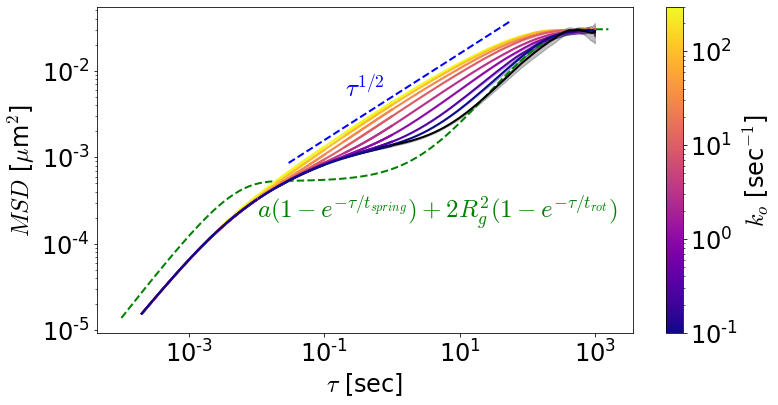

In [36]:
fig, axarr = plt.subplots(1,1, figsize=(12, 6))
# graph_msd_ax(fig, axarr, 
#              cond_path /"22-10-16_aLc1_line800_sticky55nm_kod.1-300/analysis/msd_run_data.h5", 
#              label_str="$k_o = ${}")
# Straight lines
time_arr = np.logspace(-4, 3.2, 100)
# _ = axarr.plot(time_arr[:20], .1*time_arr[:20], c='g', linestyle='--', label= "$\propto t$")
# _ = axarr.plot(time_arr[60:80], .00012*time_arr[60:80], c='g', linestyle='--', label= "$\propto t$")
# _ = axarr.plot(time_arr[2:350], .0004*np.power(time_arr[2:350],.6), c='g', linestyle='--', label= "$\propto t^{3/5}$")
# _ = axarr.plot(time_arr[:300], .001*np.power(time_arr[:300],.25), c='m', linestyle='--', label= "$\propto t^{1/4}$")
_, _, avg_rog, _ = get_param_stats(cond_path/"22-10-16_aLc1_line800_sticky55nm_kod.1-300/analysis/rog_run_data.h5")
print("Avg RoG = {avg_rog}".format(avg_rog=avg_rog))
pdict = {"viscosity": 1, 
         "kappa": 50, 
         "beta": 1./.00441, 
         "diam": .02, 
         "rog": avg_rog}
#_ = axarr.axhline(2*(avg_rog)**2, .0001, 1000, c='r', linestyle='--', label=r'$2\langle$ROG$\rangle^2$')
_ = axarr.plot(time_arr, elastica_rotation_msd(time_arr, **pdict),
                                               c='g', linestyle='--', label= r"$a(1-\exp[t/\tau_{{spring}}])+2R_g^2(1-\exp[t/\tau_{{rot}}])$")
_ = axarr.plot(time_arr[34:80], .005*np.sqrt(time_arr[34:80]), c='b', linestyle='--', label= "$\propto t^{1/2}$")
_ = axarr.text(0.2, 0.005, r"$\tau^{1/2}$", c='b', fontsize=25)
_ = axarr.text(0.01, 0.0002, r"$a(1-e^{{-\tau/t_{{spring}}}})+2R_g^2(1-e^{{-\tau/t_{{rot}}}})$", c='g', fontsize=25)
# _ = axarr.legend()


graph_msd_ax(fig, axarr, 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/analysis/msd_run_data.h5", 
             label_str="$k_o = {}$ sec$^{{-1}}$")

# Make k_o = .0001 curve
make_single_graph_msd(fig, axarr, 
                      cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.1/analysis/msd_run_data.h5", 
                      key='0.0001', label_str="$k_o = {}$ sec$^{{-1}}$",show_legend=False) 

make_single_graph_msd(fig, axarr, 
                      cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.01/analysis/msd_run_data.h5", 
                      key='0.0001', label_str="$k_o = {}$ sec$^{{-1}}$", fend_cut_ind = -9900, show_legend=False) 
make_single_graph_msd(fig, axarr, 
                      cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.001/analysis/msd_run_data.h5", 
                      key='0.0001', label_str="$k_o = {}$ sec$^{{-1}}$", fend_cut_ind = -9900, show_legend=False) 
make_single_graph_msd(fig, axarr, 
                      cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.0001/analysis/msd_run_data.h5", 
                      key='0.0001', label_str="$k_o = {}$ sec$^{{-1}}$", fend_cut_ind = -9900, show_legend=False) 

# Make the rest of the graphs
graph_msd_ax(fig, axarr, 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01/analysis/msd_run_data.h5", 
             label_str="$k_o = {}$ sec$^{{-1}}$", 
             show_legend=False, 
             send_cut_ind = 2, fend_cut_ind = -9900)
graph_msd_ax(fig, axarr, 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.001/analysis/msd_run_data.h5", 
             label_str="$k_o = {}$ sec$^{{-1}}$", 
             show_legend=False, fend_cut_ind = -9900)
graph_msd_ax(fig, axarr, 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.0001/analysis/msd_run_data.h5", 
             label_str="$k_o = {}$ sec$^{{-1}}$", 
             show_legend=False, fend_cut_ind = -9900)

cmap = plb.cm.plasma
norm = mpl.colors.LogNorm(vmin=.1, vmax=300)
cb= fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axarr, label='$k_o$ [sec$^{-1}$]')

(0.1, 1000)

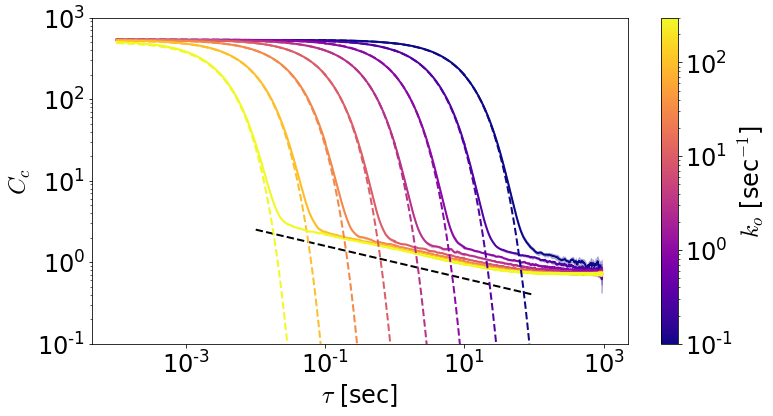

In [ ]:
fig, axarr = plt.subplots(1,1, figsize=(12, 6))
x = np.linspace(.01,100)
y = np.power(x,-.2)
_ = axarr.plot(x,y, linestyle='--', color='k', label=r'$\propto t^{-1/5}$')
graph_connect_ac_ax(fig, axarr, 
                    cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/analysis/connect_run_data.h5",
                    label_str='$k_o = ${} sec$^{{-1}}$',
                    show_legend=False, 
                    send_cut_ind=100, fend_cut_ind=-500)
graph_connect_ac_ax(fig, axarr, 
                    cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01/analysis/connect_run_data.h5",
                    label_str='$k_o = ${}',
                    show_legend=False, 
                    send_cut_ind = 100, fend_cut_ind = -9000)
graph_connect_ac_ax(fig, axarr, 
                    cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.001/analysis/connect_run_data.h5",
                    label_str='$k_o = ${}',
                    show_legend=False, 
                    send_cut_ind = 100, fend_cut_ind = -9000)
graph_connect_ac_ax(fig, axarr, 
                    cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.0001/analysis/connect_run_data.h5",
                    label_str='$k_o = ${}',
                    show_legend=False, 
                    send_cut_ind = 2, fend_cut_ind = -9000, add_exp_fit=True)
cmap = plb.cm.plasma
norm = mpl.colors.LogNorm(vmin=.1, vmax=300)
cb= fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axarr, label='$k_o$ [sec$^{-1}$]')

axarr.set_ylim(.1, 1000)


# Supplemental figures

Avg RoG = 0.12199690192937851
Tau bead =  0.003769911184307752
Tau rot =  146.33987313678915


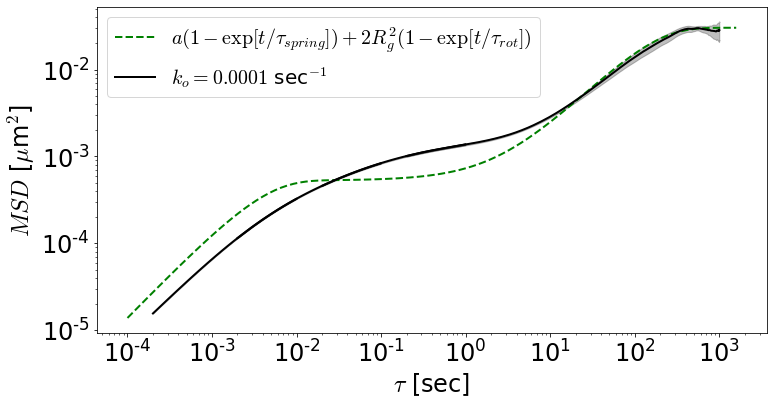

In [71]:
fig, axarr = plt.subplots(1,1, figsize=(12, 6))
time_arr = np.logspace(-4, 3.2, 100)
_, _, avg_rog, _ = get_param_stats(cond_path/"22-10-16_aLc1_line800_sticky55nm_kod.1-300/analysis/rog_run_data.h5")
print("Avg RoG = {avg_rog}".format(avg_rog=avg_rog))
pdict = {"viscosity": 1, 
         "kappa": 50, 
         "kappa1": 50, 
         "kappa2": 3650, 
         "beta": 1./.00441, 
         "diam": .02, 
         "rog": avg_rog}
_ = axarr.plot(time_arr, elastica_rotation_msd(time_arr, **pdict),
                                               c='g', linestyle='--', label= r"$a(1-\exp[t/\tau_{{spring}}])+2R_g^2(1-\exp[t/\tau_{{rot}}])$")


make_single_graph_msd(fig, axarr, 
                      cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.1/analysis/msd_run_data.h5", 
                      key='0.0001', label_str="$k_o = {}$ sec$^{{-1}}$",show_legend=False) 
axarr.legend()

make_single_graph_msd(fig, axarr, 
                      cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.01/analysis/msd_run_data.h5", 
                      key='0.0001', label_str="$k_o = {}$ sec$^{{-1}}$", fend_cut_ind = -9900) 
make_single_graph_msd(fig, axarr, 
                      cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.001/analysis/msd_run_data.h5", 
                      key='0.0001', label_str="$k_o = {}$ sec$^{{-1}}$", fend_cut_ind = -9900) 
make_single_graph_msd(fig, axarr, 
                      cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.0001/analysis/msd_run_data.h5", 
                      key='0.0001', label_str="$k_o = {}$ sec$^{{-1}}$", fend_cut_ind = -9900) 

fig.savefig("msd_ko.png", dpi=300, bbox_inches='tight')

Avg RoG = 0.12199690192937851
Tau bead =  0.003769911184307752
Tau rot =  146.33987313678915
Tau bead1 =  0.003769911184307752
Tau bead2 =  0.003769911184307752
Tau rot =  146.33987313678915


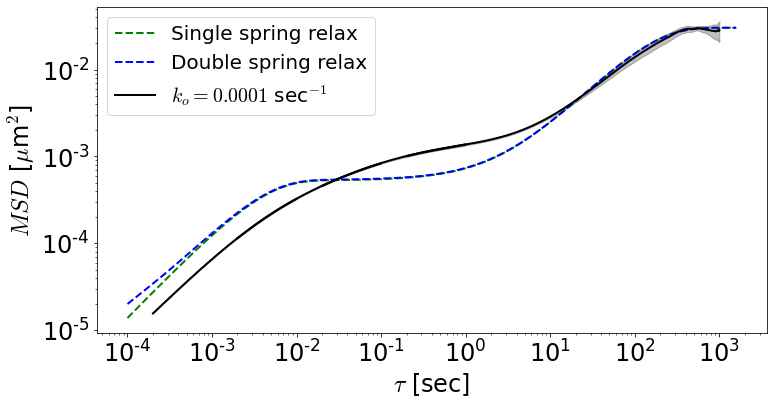

In [70]:
fig, axarr = plt.subplots(1,1, figsize=(12, 6))
time_arr = np.logspace(-4, 3.2, 100)
_, _, avg_rog, _ = get_param_stats(cond_path/"22-10-16_aLc1_line800_sticky55nm_kod.1-300/analysis/rog_run_data.h5")
print("Avg RoG = {avg_rog}".format(avg_rog=avg_rog))
pdict = {"viscosity": 1, 
         "kappa": 50, 
         "kappa1": 50, 
         "kappa2": 3650, 
         "beta": 1./.00441, 
         "diam": .02, 
         "rog": avg_rog}
_ = axarr.plot(time_arr, elastica_rotation_msd(time_arr, **pdict),
                                               c='g', linestyle='--', label= r"Single spring relax")
_ = axarr.plot(time_arr, elastica_2species_rotation_msd(time_arr, **pdict),
                                               c='b', linestyle='--', label= r"Double spring relax")


make_single_graph_msd(fig, axarr, 
                      cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.1/analysis/msd_run_data.h5", 
                      key='0.0001', label_str="$k_o = {}$ sec$^{{-1}}$",show_legend=False) 
axarr.legend()

make_single_graph_msd(fig, axarr, 
                      cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.01/analysis/msd_run_data.h5", 
                      key='0.0001', label_str="$k_o = {}$ sec$^{{-1}}$", fend_cut_ind = -9900) 
make_single_graph_msd(fig, axarr, 
                      cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.001/analysis/msd_run_data.h5", 
                      key='0.0001', label_str="$k_o = {}$ sec$^{{-1}}$", fend_cut_ind = -9900) 
make_single_graph_msd(fig, axarr, 
                      cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.0001/analysis/msd_run_data.h5", 
                      key='0.0001', label_str="$k_o = {}$ sec$^{{-1}}$", fend_cut_ind = -9900) 

fig.savefig("msd_ko.png", dpi=300, bbox_inches='tight')

Avg RoG = 0.12199690192937851
Tau bead =  5.164261896311989e-05
Tau rot =  146.33987313678915


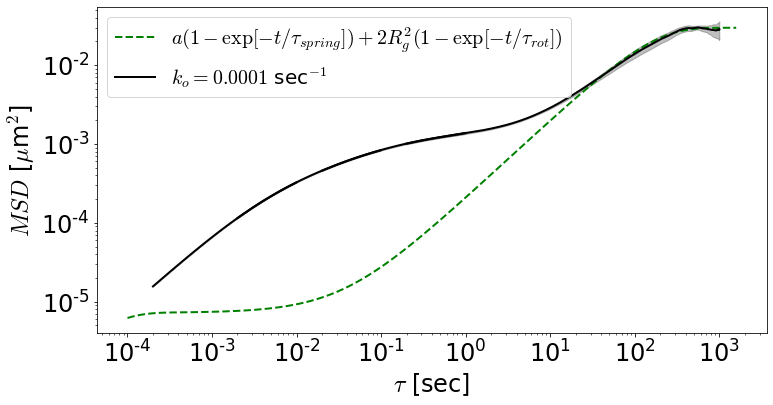

In [72]:
fig, axarr = plt.subplots(1,1, figsize=(12, 6))
time_arr = np.logspace(-4, 3.2, 100)
_, _, avg_rog, _ = get_param_stats(cond_path/"22-10-16_aLc1_line800_sticky55nm_kod.1-300/analysis/rog_run_data.h5")
print("Avg RoG = {avg_rog}".format(avg_rog=avg_rog))
pdict = {"viscosity": 1, 
         "kappa": 3650, 
         "beta": 1./.00441, 
         "diam": .02, 
         "rog": avg_rog}
_ = axarr.plot(time_arr, elastica_rotation_msd(time_arr, **pdict),
                                               c='g', linestyle='--', label= r"$a(1-\exp[-t/\tau_{{spring}}])+2R_g^2(1-\exp[-t/\tau_{{rot}}])$")


make_single_graph_msd(fig, axarr, 
                      cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.1/analysis/msd_run_data.h5", 
                      key='0.0001', label_str="$k_o = {}$ sec$^{{-1}}$",show_legend=False) 
axarr.legend()

make_single_graph_msd(fig, axarr, 
                      cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.01/analysis/msd_run_data.h5", 
                      key='0.0001', label_str="$k_o = {}$ sec$^{{-1}}$", fend_cut_ind = -9900) 
make_single_graph_msd(fig, axarr, 
                      cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.001/analysis/msd_run_data.h5", 
                      key='0.0001', label_str="$k_o = {}$ sec$^{{-1}}$", fend_cut_ind = -9900) 
make_single_graph_msd(fig, axarr, 
                      cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.0001/analysis/msd_run_data.h5", 
                      key='0.0001', label_str="$k_o = {}$ sec$^{{-1}}$", fend_cut_ind = -9900) 

fig.savefig("msd_ko.png", dpi=300, bbox_inches='tight')

## Non-brownian and stationary results

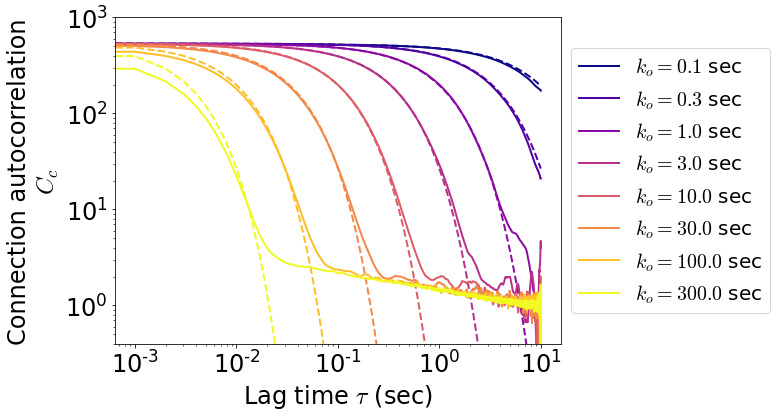

In [64]:
# fig, axarr = plt.subplots(1,1, figsize=(8, 6))
# graph_connect_ac_ax(fig, axarr, 
#                     cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.001/analysis/connect_run_data.h5",
#                     label_str='$k_o = ${}')
record_path = cond_path /  "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.001/simulations"
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
kod_list = []
sim_dirs = []
for data_path in record_path.glob('ko*'):
    with h5py.File(next(data_path.glob('s1/analysis/raw*.h5')), 'r') as h5_data_raw:
        param_dict = yaml.safe_load(h5_data_raw.attrs['ProteinConfig'])['proteins'][0]
        kod_list += [float(param_dict['ko_d'][1])]
        sim_dirs += [data_path]


sim_dirs = [x for _,x in sorted(zip(kod_list, sim_dirs))]
kod_list = sorted(kod_list)
log_pvs = np.log10(kod_list)
log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
colors = plb.cm.plasma(log_pvs)

for i, sdir in enumerate(sim_dirs):
    with h5py.File(next(sdir.glob('s1/analysis/connect_analysis.h5')), 'r') as h5_data:

        time_arr = h5_data['time']
        ac_arr = h5_data['autocorr']
        _ = axarr.plot(time_arr[:ac_arr.size], ac_arr, color=colors[i], label=f'$k_o = {kod_list[i]}$ sec')
        _ = axarr.plot(time_arr[:ac_arr.size], ac_arr[0]*np.exp(-kod_list[i]*time_arr[:ac_arr.size]), color=colors[i], linestyle='--')

_ = axarr.set_yscale('log')
_ = axarr.set_xscale('log')
# _ axarr.xlim(.1, 10)
_ = axarr.set_ylim(.4, 1000)
_ = axarr.set_ylabel('Connection autocorrelation\n' + r'$C_c$')
_ = axarr.set_xlabel(r'Lag time $\tau$ (sec)')
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.0, .5))

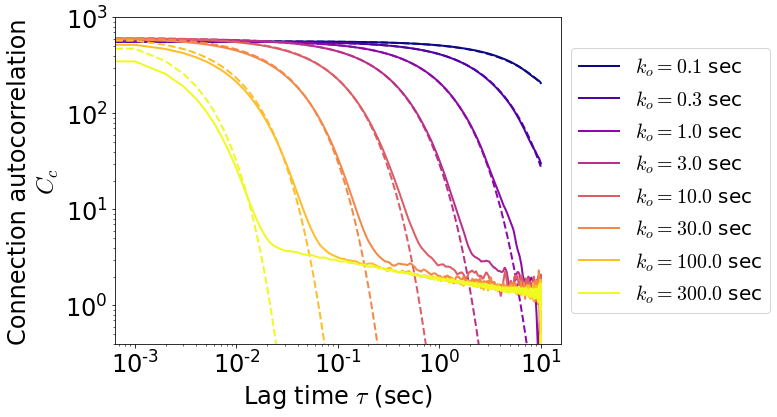

In [61]:
record_path = cond_path / '23-05-27_aLc1_line800_sticky55nm_kod0.1-300_tsnap.001_NB/simulations'
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
kod_list = []
sim_dirs = []
for data_path in record_path.glob('ko*'):
    with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r') as h5_data_raw:
        param_dict = yaml.safe_load(h5_data_raw.attrs['ProteinConfig'])['proteins'][0]
        kod_list += [float(param_dict['ko_d'][1])]
        sim_dirs += [data_path]


sim_dirs = [x for _,x in sorted(zip(kod_list, sim_dirs))]
kod_list = sorted(kod_list)
log_pvs = np.log10(kod_list)
log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
colors = plb.cm.plasma(log_pvs)

for i, sdir in enumerate(sim_dirs):
    with h5py.File(next(sdir.glob('analysis/connect_analysis.h5')), 'r') as h5_data:

        time_arr = h5_data['time']
        ac_arr = h5_data['autocorr']
        _ = axarr.plot(time_arr[:ac_arr.size], ac_arr, color=colors[i], label=f'$k_o = {kod_list[i]}$ sec')
        _ = axarr.plot(time_arr[:ac_arr.size], ac_arr[0]*np.exp(-kod_list[i]*time_arr[:ac_arr.size]), color=colors[i], linestyle='--')

_ = axarr.set_yscale('log')
_ = axarr.set_xscale('log')
# _ axarr.xlim(.1, 10)
_ = axarr.set_ylim(.4, 1000)
_ = axarr.set_ylabel('Connection autocorrelation\n' + r'$C_c$')
_ = axarr.set_xlabel(r'Lag time $\tau$ (sec)')
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.0, .5))

{'Ka': [3.22, 3.22], 'Ke': [0.662, 33.1], 'PtoAPratio': 1.0, 'diffBoundD': [0.0, 0.0], 'diffBoundS': [0.0, 0.0], 'diffUnbound': 0.01, 'eps': 1.0, 'fixedEnd0': True, 'fixedLocationPerMT': [0.0], 'freeLength': 0.055, 'freeNumber': 0, 'fstall': 5.0, 'kappa': 50.0, 'ko_d': [0, 1.0], 'ko_s': [0.0, 0.0], 'lambda': 0.0, 'rc': 0.039, 'tag': 0, 'useBindVol': False, 'vdrag': [False, False], 'vmax': [0.0, 0.0], 'walkOff': False}
{'Ka': [3.22, 3.22], 'Ke': [0.662, 33.1], 'PtoAPratio': 1.0, 'diffBoundD': [0.0, 0.0], 'diffBoundS': [0.0, 0.0], 'diffUnbound': 0.01, 'eps': 1.0, 'fixedEnd0': True, 'fixedLocationPerMT': [0.0], 'freeLength': 0.055, 'freeNumber': 0, 'fstall': 5.0, 'kappa': 50.0, 'ko_d': [0, 0.1], 'ko_s': [0.0, 0.0], 'lambda': 0.0, 'rc': 0.039, 'tag': 0, 'useBindVol': False, 'vdrag': [False, False], 'vmax': [0.0, 0.0], 'walkOff': False}
{'Ka': [3.22, 3.22], 'Ke': [0.662, 33.1], 'PtoAPratio': 1.0, 'diffBoundD': [0.0, 0.0], 'diffBoundS': [0.0, 0.0], 'diffUnbound': 0.01, 'eps': 1.0, 'fixedEnd0

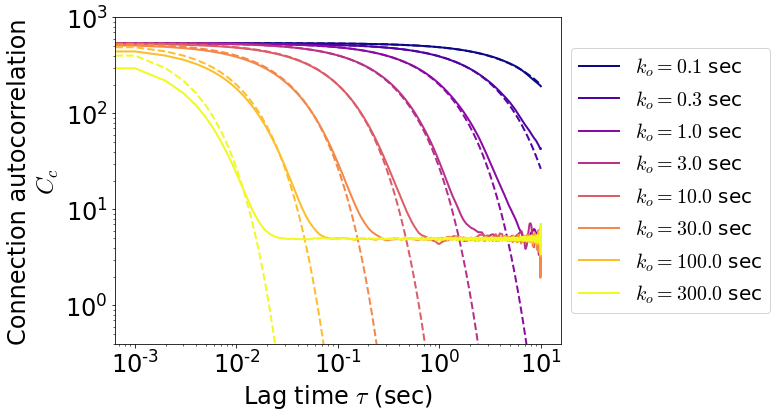

In [60]:
record_path = cond_path / '23-05-27_aLc1_line800_sticky55nm_kod.1-300_tsnap.001_ST/simulations'
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
kod_list = []
sim_dirs = []
for data_path in record_path.glob('ko*'):
    with h5py.File(next(data_path.glob('analysis/raw*.h5')), 'r') as h5_data_raw:
        param_dict = yaml.safe_load(h5_data_raw.attrs['ProteinConfig'])['proteins'][0]
        kod_list += [float(param_dict['ko_d'][1])]
        sim_dirs += [data_path]


sim_dirs = [x for _,x in sorted(zip(kod_list, sim_dirs))]
kod_list = sorted(kod_list)
log_pvs = np.log10(kod_list)
log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
colors = plb.cm.plasma(log_pvs)

for i, sdir in enumerate(sim_dirs):
    with h5py.File(next(sdir.glob('analysis/connect_analysis.h5')), 'r') as h5_data:

        time_arr = h5_data['time']
        ac_arr = h5_data['autocorr']
        _ = axarr.plot(time_arr[:ac_arr.size], ac_arr, color=colors[i], label=f'$k_o = {kod_list[i]}$ sec')
        _ = axarr.plot(time_arr[:ac_arr.size], ac_arr[0]*np.exp(-kod_list[i]*time_arr[:ac_arr.size]), color=colors[i], linestyle='--')

_ = axarr.set_yscale('log')
_ = axarr.set_xscale('log')
# _ axarr.xlim(.1, 10)
_ = axarr.set_ylim(.4, 1000)
_ = axarr.set_ylabel('Connection autocorrelation\n' + r'$C_c$')
_ = axarr.set_xlabel(r'Lag time $\tau$ (sec)')
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.0, .5))

# Saving data

In [ ]:
# save_connect_data(cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1", 
#                   param_str="kod")
# save_connect_data(cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01", 
#                   param_str="kod")
# save_connect_data(cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.001", 
#                   param_str="kod")
# save_connect_data(cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.0001", 
#                   param_str="kod")